# Chapter 6: Joins, Pivots, and USGS dataRetrieval

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2026-02-05

# Joins, Pivots, and USGS dataRetrieval

Use Template Repository from
github:<https://github.com/VT-Hydroinformatics/6-Get-Format-Plot-HydroData>

Readings: Introduction to the dataRetrieval package
<https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html>

Chapter 12 & 13 of R for Data Science
<https://r4ds.had.co.nz/tidy-data.html>

## Goals for today

-   Get familiar with the dataRetrieval package
-   Intro to joins
-   Learn about long vs. wide data and how to change between them

Prep question: How would you get data from the USGS NWIS (non-R)?

Install the dataRetrieval package. Load it and the tidyverse.

In [ ]:
#install.packages("dataRetrieval")
library(dataRetrieval)

## Exploring what dataRetrieval can do.

Think about the dataRetrieval as a way to interact with the same public
data you can access through waterdata.usgs.gov but without having to
click on buttons and search around. It makes getting data or doing
analyses with USGS data much more reproducible and fast!

To explore a few of the capabilities (NOT ALL!!) we will start with the
USGS gage on the New River at Radford. The gage number is 03171000.

The documentation for the package is extremely helpful:
<https://cran.r-project.org/web/packages/dataRetrieval/vignettes/dataRetrieval.html>

I always have to look up how to do things because the package is very
specialized! This is the case with most website APIs, in my experience.
It’s a good argument for getting good at navigating package
documentation! Basically you just look through and try to piece together
the recipe for what you want to do using the examples they give in the
document.

First, let’s get information about the site using the
read_waterdata_monitoring_location() and read_waterdata_ts_meta()
functions. Try each out and see what they tell you.

Remember, all the parameter codes and site names get passed to
dataRetrieval functions as characters, so they must be in quotes and
site numbers must have “USGS-” at the front.

In [ ]:
#important: note the site number gets input as a character with agency code prefix
site <- "USGS-03171000"

#Information about the site
siteinfo <- read_waterdata_monitoring_location(
            monitoring_location_id=site)

Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/monitoring-locations/items?f=json&lang=en-US&limit=50000&id=USGS-03171000

Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/time-series-metadata/items?f=json&lang=en-US&skipGeometry=TRUE&monitoring_location_id=USGS-03171000&statistic_id=00003&computation_period_identifier=Daily&limit=50000

# A tibble: 3 × 21
  unit_of_measure parameter_name       parameter_code statistic_id
  <chr>           <chr>                <chr>          <chr>       
1 degC            Temperature, water   00010          00003       
2 uS/cm           Specific cond at 25C 00095          00003       
3 ft^3/s          Discharge            00060          00003       
# ℹ 17 more variables: hydrologic_unit_code <chr>, state_name <chr>,
#   last_modified <dttm>, begin <dttm>, end <dttm>, begin_utc <dttm>,
#   end_utc <dttm>, computation_period_identifier <chr>,
#   computation_identifier <chr>, thresholds <chr>,
#   sublocation_identifier <chr>, primary <chr>, monitoring_location_id <chr>,
#   web_description <chr>, parameter_description <chr>,
#   parent_time_series_id <chr>, time_series_id <chr>

## Joins

If you look at dataAvailable, you’ll see it contains the USGS site
number, but not the name of the site. This makes it challenging to
interpret if you are a human who prefers words to long sequences of
numbers.

The site name is in the siteinfo object, and it’s easy enough to look
there for one site. However, we often have many sites, so we need a
better way to add this information to our data.

Enter JOINS!

Joins allow us to combine the data from two different data sets that
have a column in common. At its most basic, a join looks for a matching
row with the same key in both datasets (for example, a USGS gage number)
and then combines the rows. So now you have all the data from both sets,
matched on the key.

But you have to make some decisions: what if a key value exists in one
set but not the other? Do you just drop that observation? Do you add an
NA? Let’s look at the different options.

Take for example the two data sets, FlowTable and SizeTable. The
SiteName values are the key values and the MeanFlow and WSsize values
are the data.

![](attachment:images/joinsetup.png "Join setup")

*Join setup*

Note River1 and River2 match up, but River3 and River5 only exist in one
data set or the other.

The first way to deal with this is an **INNER JOIN: inner_join()** In an
inner join, you only keep records that match. So the rows for River3 and
River5 will be dropped because there is no corresponding data in the
other set. See below:

![](attachment:images/innerjoin.png "Inner Join")

*Inner Join*

But what if you don’t want to lose the values in one or the other or
both?!

For instance, let’s say you have a bunch of discharge data for a stream,
and then chemistry grab samples. You want to join the chemistry to the
discharge based on the dates and times they were taken. But when you do
this, you don’t want to delete all the discharge data where there is no
chemistry! We need another option. Enter OUTER JOINS

**LEFT JOIN, left_join():** Preserves all values from the LEFT data set,
and pastes on the matching ones from the right. This creates NAs where
there is a value on the left but not the right. (this is what you’d want
to do in the discharge - chemistry example above)

![](attachment:images/leftjoin1.png "Left Join")

*Left Join*

**RIGHT JOIN, right_join():** Preserves all values from the RIGHT data
set, and pastes on the matching ones from the left. This creates NAs
where there is a value on the right but not the left.

![](attachment:images/rightjoin.png "Right Join")

*Right Join*

**FULL JOIN, full_join():** KEEP EVERYTHING! The hoarder of the joins.
No matching record on the left? create an NA on the right! No matching
value on the right? Create an NA on the left! NAs for everyone!

![](attachment:images/fulljoin.png "Full Join")

*Full Join*

When you do this in R, you use the functions identified in the
descriptions with the following syntax (see example below):

**if the column is named the same in both data sets** \>
xxx_join(left_tibble, right_tibble, by = “key_column”)\*\*

**if the column is named differently in both data sets** \>
xxx_join(left_tibble, right_tibble, by = c(“left_key” = “right_key”)

![](attachment:images/leftjoin2.png "Left Join with differing column names")

*Left Join with differing column names*

Note in both of the above, when you specify which column to use as “by”
you have to put it in quotes.

## Join example

So in the chunk below let’s get add the site name by joining the
dataAvailable and siteinfo tibbles. They both have the column
“monitoring_location_id”, so we can join on that.

What if the same information is in two columns that have different
names? Good question! You can do that using the syntax by =
c(“left_column” = “right_column”). Clumsy, but we will do an example
later.
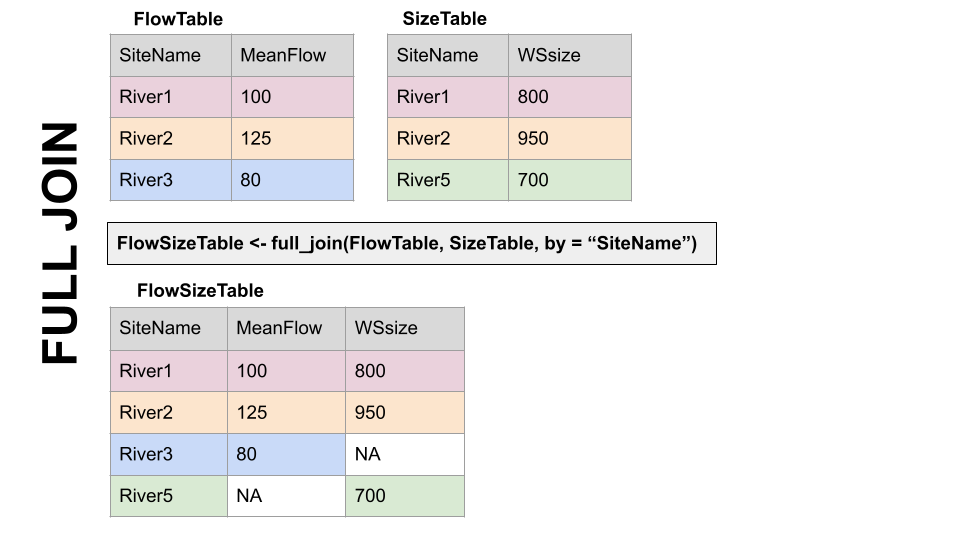
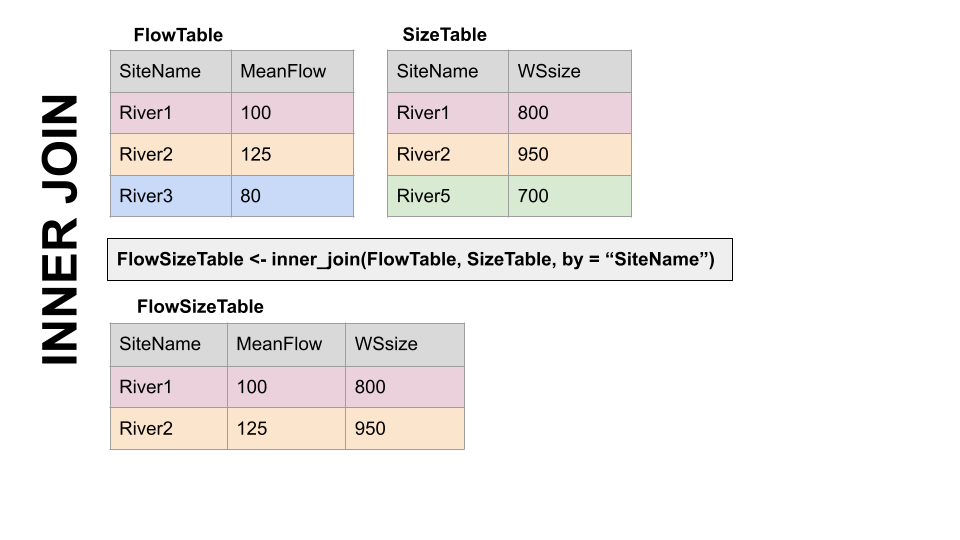
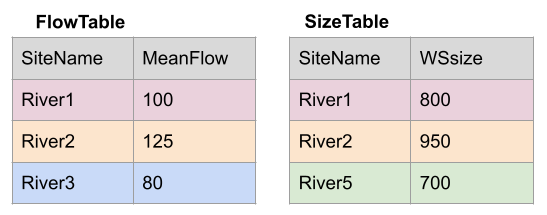
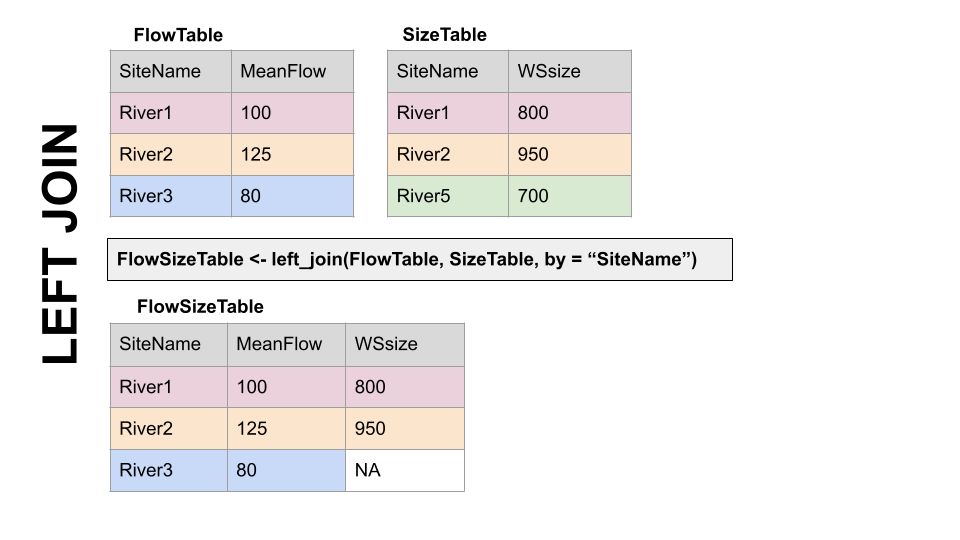
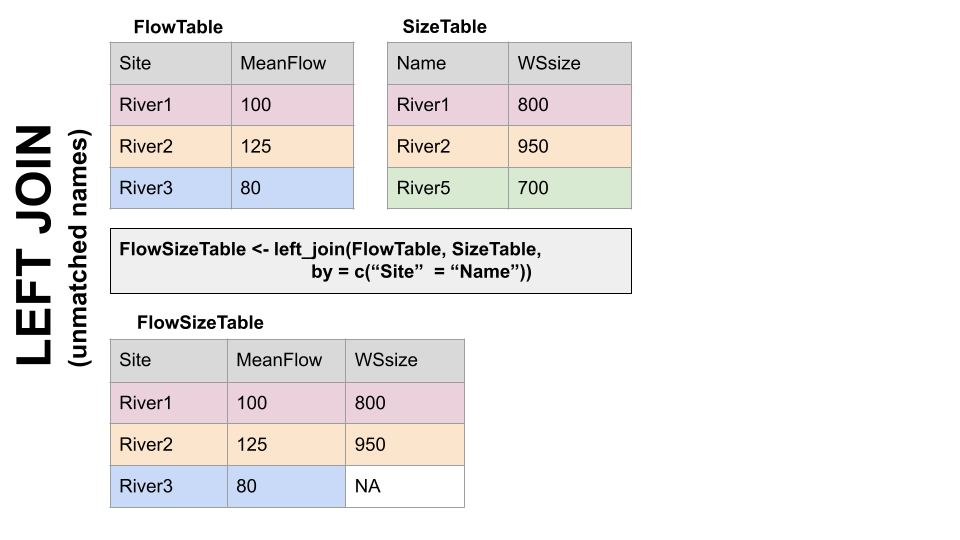
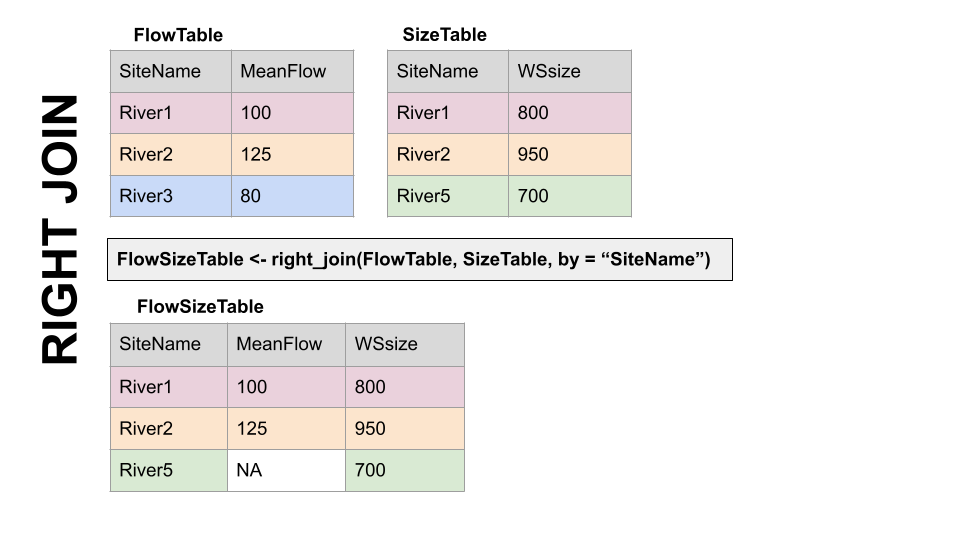

In [ ]:
dataAvailable <- left_join(dataAvailable, siteinfo, 
                           by = "monitoring_location_id")

dataAvailable

# A tibble: 3 × 61
  unit_of_measure parameter_name       parameter_code statistic_id
  <chr>           <chr>                <chr>          <chr>       
1 degC            Temperature, water   00010          00003       
2 uS/cm           Specific cond at 25C 00095          00003       
3 ft^3/s          Discharge            00060          00003       
# ℹ 57 more variables: hydrologic_unit_code.x <chr>, state_name.x <chr>,
#   last_modified <dttm>, begin <dttm>, end <dttm>, begin_utc <dttm>,
#   end_utc <dttm>, computation_period_identifier <chr>,
#   computation_identifier <chr>, thresholds <chr>,
#   sublocation_identifier <chr>, primary <chr>, monitoring_location_id <chr>,
#   web_description <chr>, parameter_description <chr>,
#   parent_time_series_id <chr>, time_series_id <chr>, agency_code <chr>, …

# A tibble: 3 × 7
  monitoring_location_id monitoring_location_name parameter_code parameter_name 
  <chr>                  <chr>                    <chr>          <chr>          
1 USGS-03171000          NEW RIVER AT RADFORD, VA 00010          Temperature, w…
2 USGS-03171000          NEW RIVER AT RADFORD, VA 00095          Specific cond …
3 USGS-03171000          NEW RIVER AT RADFORD, VA 00060          Discharge      
# ℹ 3 more variables: parameter_description <chr>, begin <dttm>, end <dttm>

## Finding IDs to download USGS data

You can find sites via map and just enter the id like we did in the
chunks above: <https://maps.waterdata.usgs.gov/mapper/index.html>

Below we will look at two other ways to get sites: using a bounding box
of a geographic region, or search terms like State.

Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/time-series-metadata/items?f=json&lang=en-US&skipGeometry=TRUE&bbox=-81.36%2C36.72%2C-80.27%2C37.32&properties=monitoring_location_id%2Cparameter_code%2Cbegin%2Cend&parameter_code=00060,00010&computation_period_identifier=Daily&limit=50000

# A tibble: 28 × 4
   monitoring_location_id parameter_code begin               end                
   <chr>                  <chr>          <dttm>              <dttm>             
 1 USGS-03170000          00060          1928-10-01 00:00:00 2026-02-04 00:00:00
 2 USGS-03166800          00060          1976-05-01 00:00:00 1993-09-30 00:00:00
 3 USGS-03168000          00010          2007-01-09 00:00:00 2008-09-29 00:00:00
 4 USGS-03473500          00060          1947-10-01 00:00:00 1989-09-29 00:00:00
 5 USGS-03167000          00010          2006-12-21 00:00:00 2009-06-30 00:00:00
 6 USGS-03166000          00060          1930-04-01 00:00:00 1934-09-29 00:00:00
 7 USGS-03177700          00060          1965-10-01 00:00:00 1980-09-29 00:00:00
 8 USGS-03167000          00060          1908-10-01 00:00:00 2026-02-03 00:00:00
 9 USGS-03175140          00060          1929-10-01 00:00:00 1932-09-29 00:00:00
10 USGS-03172500          00060          1908-10-01 00:00:00 1916-09-29 00:00:00
# ℹ 18 mo

Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/monitoring-locations/items?f=json&lang=en-US&properties=agency_code&state_name=Virginia&site_type=Stream&limit=50000

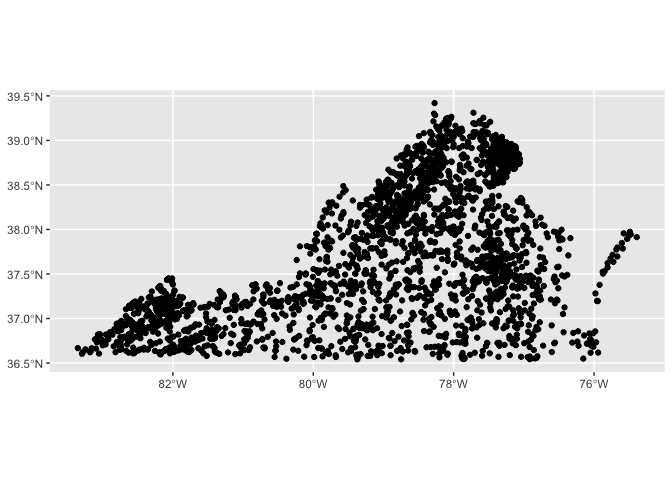

In [ ]:
#find sites in a bounding box
#coords of bottom left, top right
swva <- c(-81.36, 36.72, -80.27, 37.32)

#get sites in this bounding box that have daily water temperature and discharge
swva_sites <- read_waterdata_ts_meta(bbox = swva, 
                  computation_period_identifier = "Daily", 
                  parameter_code = c("00060", "00010"), 
                  properties = c("monitoring_location_id", 
                    "parameter_code",
                    "begin",
                    "end"),
                  skipGeometry=TRUE)

## OK let’s download some data!

We are going to use read_waterdata_daily(), which downloads daily
values.

We will tell it which sites to download, which parameters to download,
and then what time period to download.

monitoring_location_id gets the sites we want to download, USGS site
numbers, as a character. We will use the swva_sites data we generated
(yep, you can download multiple sites at once!)

time gets the start and end dates, together like this: time = c(start,
end). IMPORTANT: These must be in YYYY-MM-DD format, but you don’t have
to tell R they are dates before you give them to the function, it’ll do
that for you.

parameter_code is the parameters you want to download. We want water
discharge and water temperature, which are “00060” and “00010”,
respectively.

Once the data are downloaded, the temperature and discharge data are
stacked on top of each other in the same column (this is LONG data… see
later in this chapter). There is a column that tells you what each
number is measuring, but it just says the parameter code. To add
human-readable information, we can join parameter information in from
the parameterCdFile, an object that got added to your environment when
you loaded the dataRetrieval package. In Rstudio, if you click the
“GlobalEnvironment” dropdown in the “Environment” tab, and then choose
dataRetrieval, you can see this object and a couple others.

In [ ]:
start <- "2006-10-01"
end <- "2008-09-30"
params <- c("00010", "00060")

swva_dat <- read_waterdata_daily(
  monitoring_location_id = swva_sites$monitoring_location_id, 
  parameter_code = params, 
  time = c(start, end),
  skipGeometry = TRUE)|>
  left_join(parameterCdFile, by = c("parameter_code" = "parameter_cd") )

Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/daily/items?f=json&lang=en-US&skipGeometry=TRUE&monitoring_location_id=USGS-03170000,USGS-03166800,USGS-03168000,USGS-03473500,USGS-03167000,USGS-03166000,USGS-03177700,USGS-03167000,USGS-03175140,USGS-03172500,USGS-03175500,USGS-03171000,USGS-03168500,USGS-03165500,USGS-03165500,USGS-03164500,USGS-03177710,USGS-03173000,USGS-03167500,USGS-03171500,USGS-03171500,USGS-03166900,USGS-03168000,USGS-03171000,USGS-03173000,USGS-03175500,USGS-03169500,USGS-03166880&parameter_code=00010,00060&time=2006-10-01%2F2008-09-30&limit=50000

Let’s plot the water temperature data and discharge as lines and control
the color of the lines with the different sites. Because the data is
stacked together in one column, we can facet by the column that
identifies the measurements (parameter_nm) to make a combined plot of
the two.

What could be better about this plot?

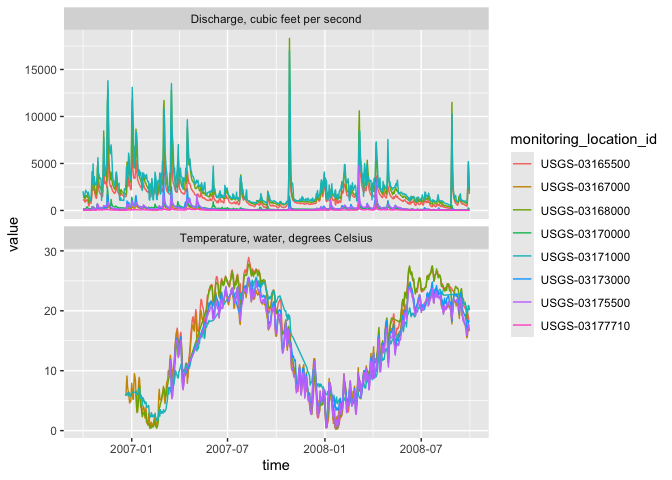

In [ ]:
swva_dat |> ggplot(aes(x = time, y = value, color = monitoring_location_id)) +
  geom_line()+
  facet_wrap(facets = ~parameter_nm, scales = "free_y", ncol = 1)

We can add site names with….More joins! Our swva_info data has the names
of the sites in human-friendly language. The column in the downloaded
data and in the swva_sites data is called “monitoring_location_id” so we
just give that to the “by” argument. Perform a left join to add the
names of the sites to the data.

Then use select to remove some of the unnecessary columns.

Then make the plot and then snazz it up with labels and a non-junky
theme.

Requesting:
https://api.waterdata.usgs.gov/ogcapi/v0/collections/monitoring-locations/items?f=json&lang=en-US&limit=50000&id=USGS-03170000,USGS-03166800,USGS-03168000,USGS-03473500,USGS-03167000,USGS-03166000,USGS-03177700,USGS-03167000,USGS-03175140,USGS-03172500,USGS-03175500,USGS-03171000,USGS-03168500,USGS-03165500,USGS-03165500,USGS-03164500,USGS-03177710,USGS-03173000,USGS-03167500,USGS-03171500,USGS-03171500,USGS-03166900,USGS-03168000,USGS-03171000,USGS-03173000,USGS-03175500,USGS-03169500,USGS-03166880

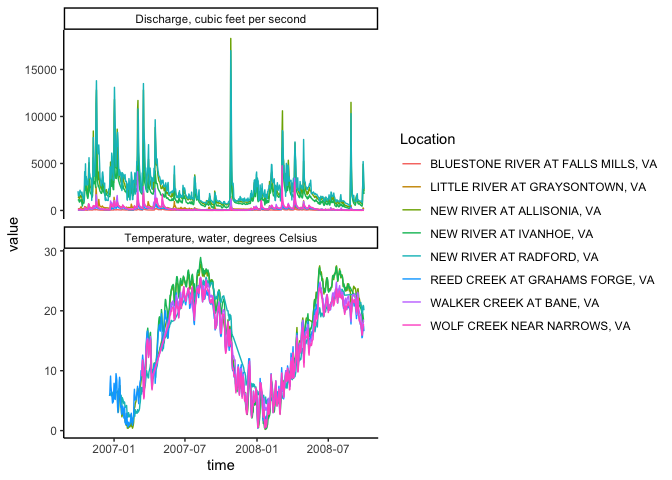

In [ ]:
swva_info <- read_waterdata_monitoring_location(
            monitoring_location_id = swva_sites$monitoring_location_id)

## Pivoting: wide and long data

Okay, so with the data above: what would you do if you wanted to
subtract the discharge or temperature of one gage from another on the
same river: to compute rate of change between the two sites, for
instance.

You could split them into two objects, then join based on date?

Or…now hear me out… you could PIVOT them.

A two-dimensional object can be either long or wide. Each has its
advantages.

**LONG**

Each observation has its own row. In the first image below, the table on
the right is long because each measurement has it’s own row. It’s value
and name are identified by other columns, and the values in that column
repeat a lot.

**WIDE**

Observations of different things have their own columns. In the first
image below, notice in the left hand table there are “Flow”, “Temp”, and
“NO3” columns rather than an identifier in a separate column like in the
table on the right.

**Why?**

Long and wide data are more efficient for different things. Think about
plotting a data set with 10 stream gages. If they are in a long format,
you can just add color = Gage to your ggplot aes(). If they are in a
wide format, meaning each gage has it’s own column, you’d have to write
a new geom for EACH gage, because they’re all in separate columns.

Now imagine you want to do some math to create new data: let’s say NO3
multiplied by Flow…. How would you even do that using the data on the
right? With the wide data on the left it is simply mutate(NO3 \* Flow).

Finally, which table is easier to read in TABLE format (not a plot) in
each of the two images below? Wide data is much more fitting for tables.

![](attachment:images/pivot_longer.png "Pivoting to a longer format")

*Pivoting to a longer format*

![](attachment:images/pivot_wider.png "Pivoting to a wider format")

*Pivoting to a wider format*

dplyr, part of the tidyverse, has functions to convert data between wide
and long data. I have to look up the syntax every single time I use
them. But they are VERY useful.

## Pivot Examples

Back to our original question: I want to subtract the flow at Ivanhoe
from the flow at Radford on the new river to see how much flow increases
between the two sites through time.

To do this I am going to use pivot_wider() to give Ivanhoe and Radford
discharges their own column.

First, we will trim to just discharge data using a filter, then use
select to trim the data to just the columns we need, then call
pivot_wider telling it which data to use for the new column names
(names_from = monitoring_location_name) and what values we want to pivot
into the data under those columns (values_from = value).

Then, subtract the two and make a plot!
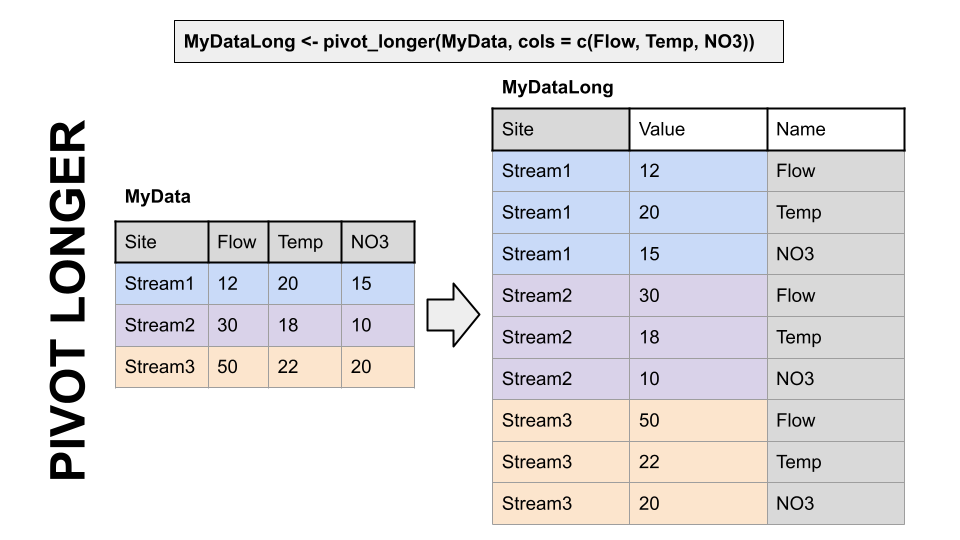
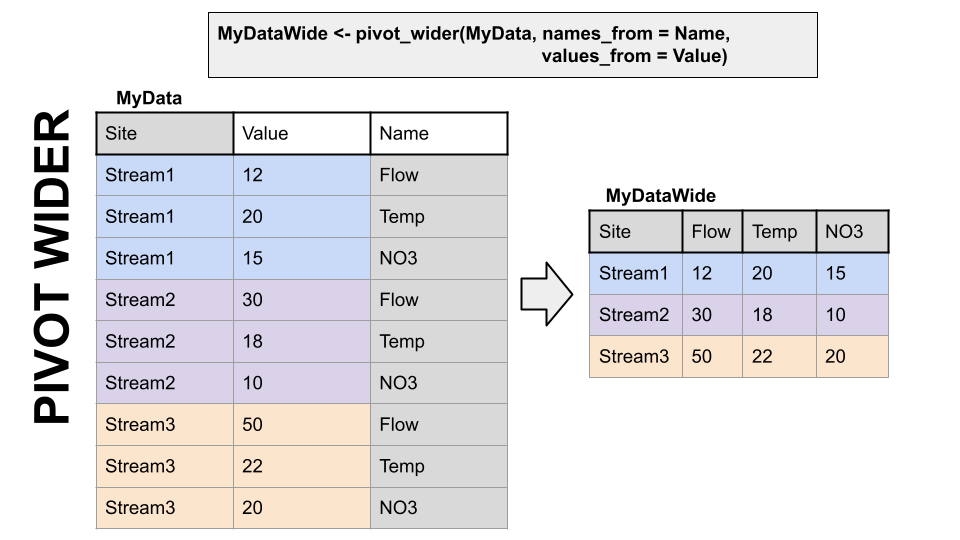

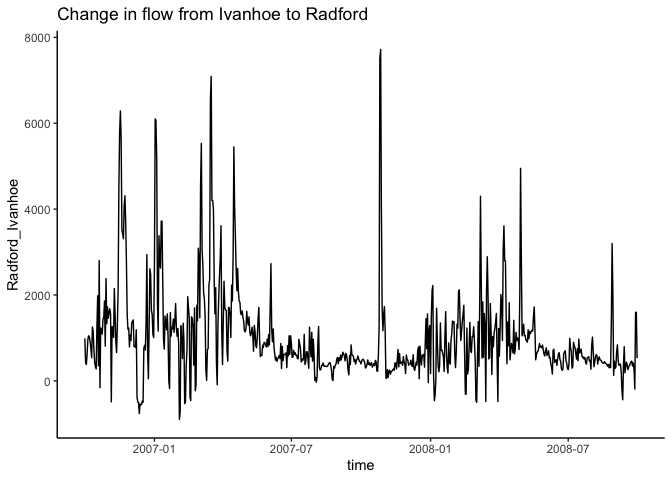

In [ ]:
#Pivot so we can compute diffs between one river and others

swva_wide <- swva_dat_clean |>
  filter(parameter_code == "00060") |>
  select(monitoring_location_name, value, time) |>
  pivot_wider(names_from = monitoring_location_name, values_from = value)

swva_wide <- swva_wide |> 
  mutate(Radford_Ivanhoe = 
           `NEW RIVER AT RADFORD, VA` - `NEW RIVER AT IVANHOE, VA`)

ggplot(swva_wide, aes(x = time, y = Radford_Ivanhoe))+
  geom_line()+
  ggtitle("Change in flow from Ivanhoe to Radford")+
  theme_classic()

To further illustrate how to move between long and wide data and when to
use them, let’s grab some water quality data. This process will also
review some of the other concepts from this topic.

In the chunk below we will find sites from our SWVA bounding box that
are on the New River and then download any data they have for chloride
and specific conductance.

We will use readWQPqw() to read the chemistry data.

In [ ]:
#site numbers for New River sites, find site with NEW RIVER in name
new_river_dat <- swva_dat_clean |>
  filter(str_detect(monitoring_location_name, "NEW RIVER")) 

new_river_sites <- unique(new_river_dat$monitoring_location_id)

#Chloride and specific conductance
params <- c("00940", "00095")

new_river_wq <- readWQPqw(siteNumbers = new_river_sites,
                         parameterCd = params)

GET: https://www.waterqualitydata.us/data/Result/search?siteid=USGS-03165500%3BUSGS-03168000%3BUSGS-03171000&count=no&pCode=00940%3B00095&mimeType=csv

NEWS: Data does not include USGS data newer than March 11, 2024. More details:
https://doi-usgs.github.io/dataRetrieval/articles/Status.html

Now, let’s clean things up a bit. Hang on tight, we are going to do a
bunch of data wrangling in one pipe sequence to accomplish what we want:
A dataset that has chloride and specific conductance in their own
columns, with a column for time, and one that says what site the
measurement was from.

This will allow us to plot Chloride vs. specific conductance

The workflow is as follows: - Create a time column that combines the
date and time columns in the downloaded data. - Select the columns we
need to pivot the data wider - Pivot wider - Rename the specific
conductance column so it doesn’t have a space in it - Join in the names
of the locations - Select just the columns we want

Finally plot chloride on the x axis, specific conductance on the y, and
color by site!

ℹ In argument: `time = ymd_hms(paste(ActivityStartDate,
  ActivityStartTime.Time))`.
Caused by warning:
!  2 failed to parse.

(`geom_point()`).

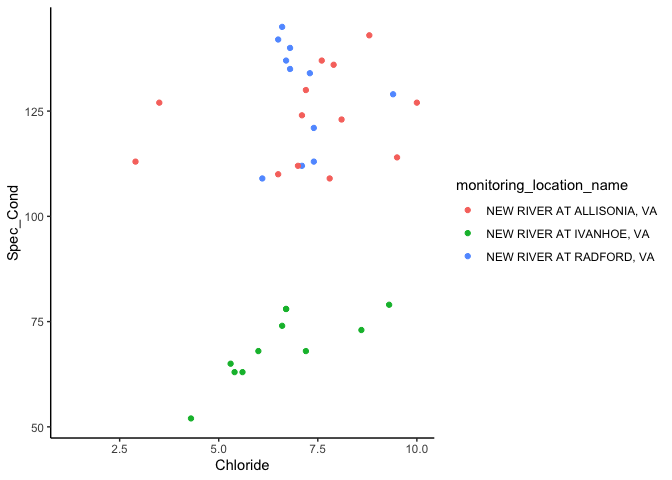

In [ ]:
nr_wq_wide <- new_river_wq |>
  mutate(time = ymd_hms(
    paste(ActivityStartDate, ActivityStartTime.Time))) |>
  select(time, 
         MonitoringLocationIdentifier, 
         CharacteristicName, 
         value = ResultMeasureValue) |>
  pivot_wider(names_from = CharacteristicName, 
              values_from = value) |>
  rename(Spec_Cond = `Specific conductance`) |>
  left_join(swva_info, 
            by = c("MonitoringLocationIdentifier" = "monitoring_location_id"))|>
  select(time, 
         monitoring_location_name, 
         MonitoringLocationIdentifier, 
         Spec_Cond, 
         Chloride)

Finally, let’s look at how to pivot the same dataset longer. An example
of why you might want to do this is if you want to make a stacked plot
with Chloride on one and specific conductance on the other, both against
time, using the ggplot facets, not making multiple plots.

So! We will pivot longer, telling pivot_longer() to pivot the column
Spec_Cond and Chloride.

When we plot this, we will see that there is one datapoint from way
before all the others, so we will filter that out so we can see the
pattern in the rest of the data.

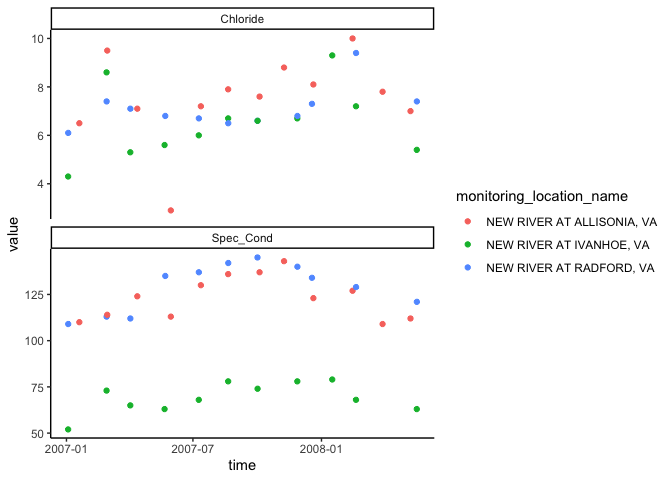

In [ ]:
#make dataset long
wqlonger <- nr_wq_wide |>
  pivot_longer(cols = Spec_Cond:Chloride)

wqlonger |> 
  filter(time > mdy("01-01-2000")) |>
  ggplot(aes(x = time, y = value, color = monitoring_location_name))+
  geom_point()+
  facet_wrap(~name, scale = "free_y", nrow = 2)+
  theme_classic()